so in the previous notebook I was having issues with the model not learning anyting. For clarity I am going to start again here and attempt to build the networks again (the previous notebook is messy af!).

My plan is to start small first and then I will begin adding the layers later, first I will resize the CelebA256 images to 32x32 and see how it goes

I will also implement WGAN-GP here. 

In [124]:
# All the imports required for this implementation
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

from torch.utils.data import TensorDataset, ConcatDataset, random_split, DataLoader, Dataset

from torchinfo import summary # Allows us to summarise the params and layers

import numpy as np
import matplotlib.pyplot as plt
import copy
import math

In [125]:
# We can make use of a GPU if you have one on your computer. This works for Nvidia and M series GPU's
if torch.backends.mps.is_available():
    device = torch.device("mps")
    # These 2 lines assign some data on the memory of the device and output it. The output confirms
    # if we have set the intended device
    x = torch.ones(1, device=device)
    print (x)
elif torch.backends.cuda.is_built():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print (x)
else:
    device = ("cpu")
    x = torch.ones(1, device=device)
    print (x)

tensor([1.], device='cuda:0')


Due to storage constraints and to keep this notebook accessible I will use a 256x256 CelebA-HQ dataset not the original 1024x1024. In the paper it is stated that train this network on smaller than 1024x1024 we can just chop off the layers until we get to 256x256

Dataset can be found at: https://www.kaggle.com/datasets/badasstechie/celebahq-resized-256x256

First let's implement the D and G given by:

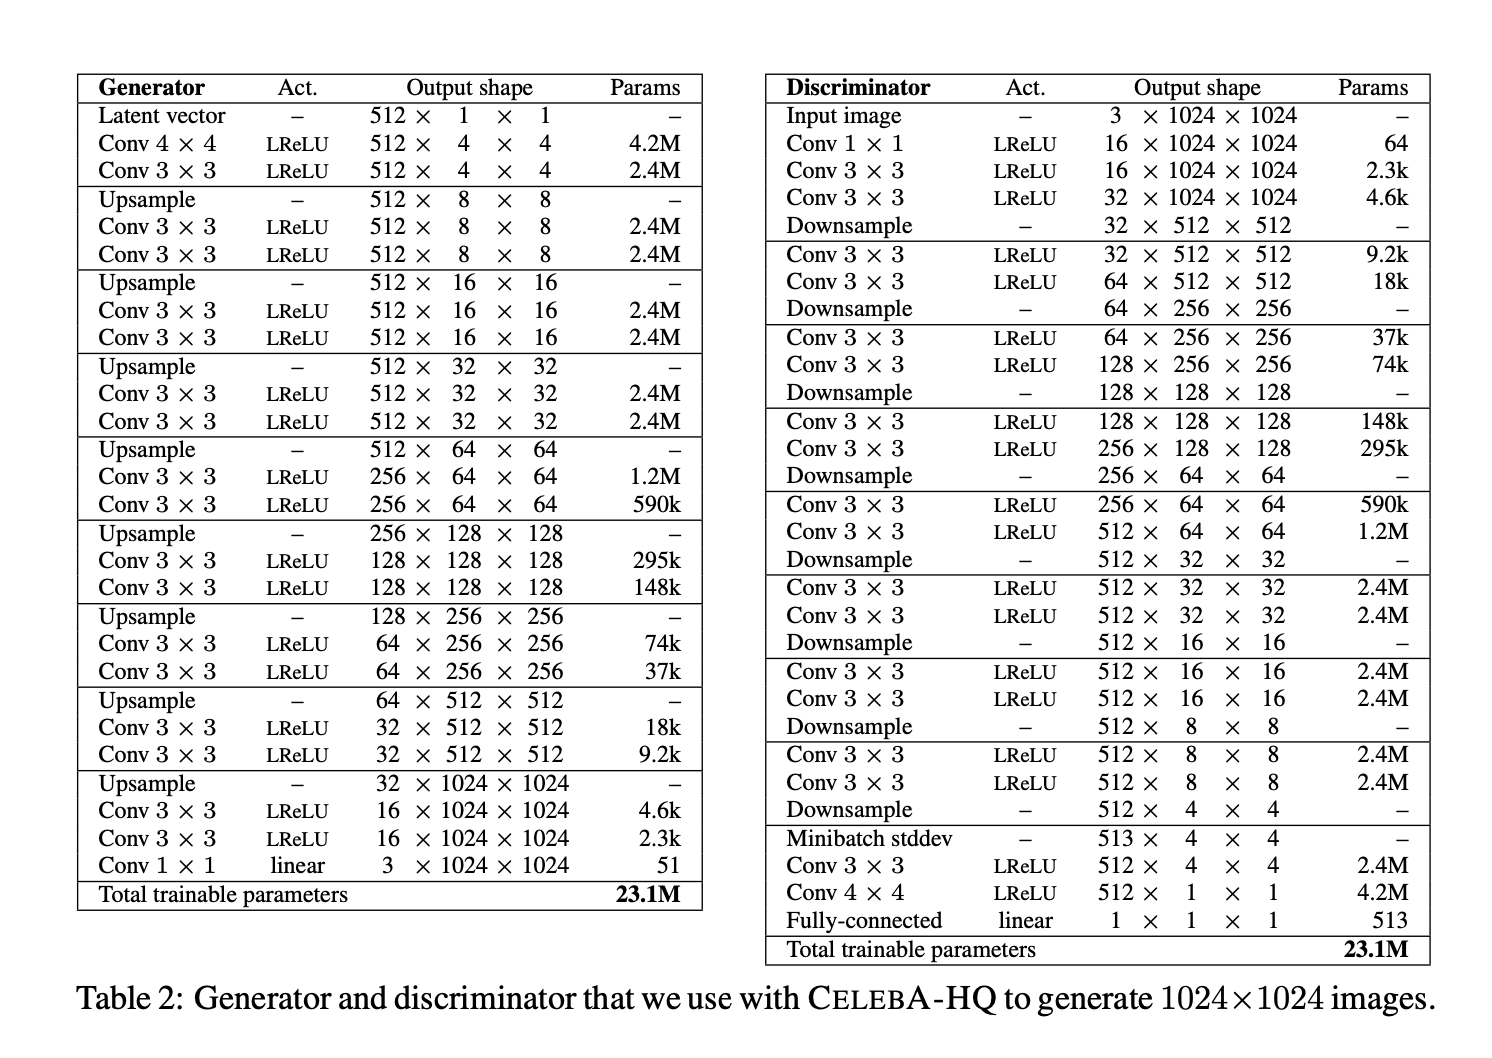

We will implement these without the other aspects they discuss in the paper and see what results we get (i.e. without the smooth intro layers with the resnet type structure, without the toRGB and fromRGB, without minibatch stdev) and let's see what we get.

In [83]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [118]:
# Load the data and display some images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32,32)),  # Resize images to 32x32
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# In the paper batch size changes as the model scales up the images to save memory, however I think with modern
# equipment we can ignore this?
batch_size = 16

# To load the data you must move the images to a folder within the dir they are in
dataset = ImageFolder(root='./celeba_hq_256', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)

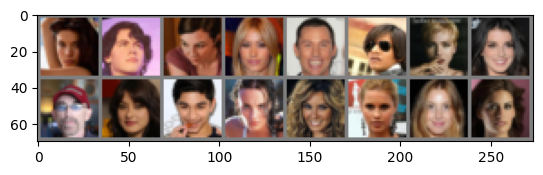

(None, tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [119]:
# get some random training images
dataiter = iter(dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images)), labels

In [157]:
class EqualizedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bias = nn.Parameter(torch.zeros(out_channels))
        
        # He's constant
        fan_in = np.prod(self.conv.weight.data.shape[1:])
        self.scale = np.sqrt(2) / np.sqrt(fan_in)
        
        # Initialize with N(0, 1)
        nn.init.normal_(self.conv.weight.data)

    def forward(self, x):
        x = self.conv(self.scale * x)
        return x + self.bias.view(1, -1, 1, 1)

class EqualizedLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
        self.bias = nn.Parameter(torch.zeros(out_features))
        
        # He's constant
        self.scale = np.sqrt(2) / np.sqrt(in_features)
        
        # Initialize with N(0, 1)
        nn.init.normal_(self.linear.weight.data)

    def forward(self, x):
        x = self.linear(self.scale * x)
        return x + self.bias

In [164]:
# Let's define a function which can generate the conv block
def d_conv_block(in_channels, out_channels, kernel_size1=None, kernel_size2=None):
    if kernel_size2 is not None:
        block = nn.Sequential(
            #nn.Conv2d(in_channels, out_channels, kernel_size1, padding=(1,1)),
            EqualizedConv2d(in_channels, out_channels, kernel_size1, padding=(1,1)),
            nn.LeakyReLU(0.2),
            #nn.Conv2d(out_channels, out_channels, kernel_size2),
            EqualizedConv2d(out_channels, out_channels, kernel_size2),
            nn.LeakyReLU(0.2),
        )
    else:
        block = nn.Sequential(
            #nn.Conv2d(in_channels, in_channels, kernel_size1, padding=(1,1)),
            EqualizedConv2d(in_channels, in_channels, kernel_size1, padding=(1,1)),
            nn.LeakyReLU(0.2),
            #nn.Conv2d(in_channels, out_channels, kernel_size1, padding=(1,1)),
            EqualizedConv2d(in_channels, out_channels, kernel_size1, padding=(1,1)),
            nn.LeakyReLU(0.2),
            # Downsample
            nn.AvgPool2d(kernel_size=(2,2)),
        )
    
    return block

def g_conv_block(in_channels, out_channels, kernel_size1=None, kernel_size2=None, upsample=False):
    if upsample:
        block = nn.Sequential(
            #nn.Conv2d(in_channels, out_channels, kernel_size1, padding=(1,1)),
            EqualizedConv2d(in_channels, out_channels, kernel_size1, padding=(1,1)),
            LRN(),
            nn.LeakyReLU(0.2),
            #nn.Conv2d(out_channels, out_channels, kernel_size1, padding=(1,1)),
            EqualizedConv2d(out_channels, out_channels, kernel_size1, padding=(1,1)),
            LRN(),
            nn.LocalResponseNorm(x.size(0), alpha=1, beta=2, k=10e-8),
            nn.LeakyReLU(0.2),
        )
    else:
        block = nn.Sequential(
            #nn.Conv2d(in_channels, out_channels, kernel_size1, padding=(3,3)),
            EqualizedConv2d(in_channels, out_channels, kernel_size1, padding=(3,3)),
            nn.LeakyReLU(0.2),
            #nn.Conv2d(out_channels, out_channels, kernel_size2, padding=(1,1)),
            EqualizedConv2d(out_channels, out_channels, kernel_size2, padding=(1,1)),
            LRN(),
            nn.LeakyReLU(0.2),
        )
    
    return block

def d_output_layer(input_dim):
    #layer = nn.Linear(input_dim, 1)
    layer = EqualizedLinear(input_dim, 1)
    return layer

def from_to_RGB(in_channels=None, out_channels=None):
    block = nn.Sequential(
        #nn.Conv2d(in_channels, out_channels, kernel_size=(1,1)),
        EqualizedConv2d(in_channels, out_channels, kernel_size=(1,1)),
        nn.LeakyReLU(0.2),
    )
    return block

def upsample(channels):
    return nn.ConvTranspose2d(in_channels=channels, out_channels=channels, kernel_size=2, stride=2)

class Mbatch_stddev(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        N, _, H, W = x.shape
    
        # First calculate the stddev for each feature in each spatial location over the batch
        # Which means calculate the stddev of each feature map
        featuremap_stddevs = torch.std(x, dim=0, unbiased=False)
        # Then average these estimates over all features and spatial locations to arrive at a single value
        mean_stddev = torch.mean(featuremap_stddevs)
        stddev_featuremap = mean_stddev * torch.ones((N, 1, H, W), device=x.device)

        x = torch.cat((x, stddev_featuremap), dim=1)

        return x

class LRN(nn.Module):
    def __init__(self, epsilon=1e-8):
        super(LRN, self).__init__()
        self.epsilon = epsilon
    
    def forward(self, x):
        square_sum = torch.pow(x, 2).sum(dim=1, keepdim=True)  # Sum across all channels
        norm_factor = torch.sqrt(square_sum / x.size(1) + self.epsilon)  # Divide by N (number of channels)
        return x / norm_factor  # Normalize

def initialize_new_layer(layer):
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(layer.weight)
        std = math.sqrt(2.0 / fan_in)
        init.normal_(layer.weight.data, mean=0, std=std)
        if layer.bias is not None:
            init.zeros_(layer.bias.data)
        

In [165]:
class Generator_32(nn.Module):
    def __init__(self):
        super().__init__()
        # Lets try using convtranspose2d for upsample
        # self.upsample = nn.Upsample(scale_factor=2, mode='nearest'
        
        self.blocks = nn.ModuleList()
        
        self.to_rgb = nn.Identity()
        self.res_to_rgb = nn.Identity()
        
        self.upsample_res = nn.Identity()
        
        # For managing res connection
        # self.block_outputs = [] This approach doesn't work for multiple inputs (e.g batches in a dataset)
        # self.prev_to_rgb = nn.Identity()
        # self.res_flag = False
        
    def forward(self, x, alpha=1):
        block_outputs = []
        
        for i, block in enumerate(self.blocks):
            '''if i == len(self.blocks) - 1:
                res_x = torch.clone(x)'''
            x = block(x)
        
        block_outputs.append(x)
        x = self.to_rgb(x)
        
        if len(block_outputs) >= 2:
        #if self.res_flag:
            res_x = block_outputs[-2]  # -2 accesses second to the front of list
            res_x = self.upsample_res(res_x)
            res_x = self.res_to_rgb(res_x)
            #res_x = self.prev_to_rgb(res_x)
            #res_x = self.upsample_res(res_x)
            
            out = ((1-alpha) * res_x) + (alpha * x)
        else:
            out = x
        
        return out
    
    def add_gen_block(self, layer_num):
        all_out_channels = [512, 256, 128, 64]  # The number of output channels for layer 1 - 4
        # new_params keeps track of new params for optimiser
        new_params = []
        
        def init_and_add(module):
            '''for layer in module.modules():
                initialize_new_layer(layer)'''
            new_params.extend(module.parameters())
        
        if layer_num == 0:
            self.blocks.append(g_conv_block(in_channels=512, out_channels=512, kernel_size1=(4,4), kernel_size2=(3,3))).to(device)
            init_and_add(self.blocks[-1])
            self.to_rgb = from_to_RGB(in_channels=512, out_channels=3).to(device)
            init_and_add(self.to_rgb)
        else:
            in_channels = all_out_channels[layer_num] * 2
            out_channels = all_out_channels[layer_num]
            # Upsample before appending new layer
            self.blocks.append(upsample(in_channels).to(device))
            init_and_add(self.blocks[-1])
            self.blocks.append(g_conv_block(in_channels=in_channels, out_channels=out_channels, kernel_size1=(3,3), kernel_size2=(3,3), upsample=True).to(device))
            init_and_add(self.blocks[-1])
            
            # Store old to_rgb
            # self.prev_to_rgb = self.to_rgb
            
            self.to_rgb = from_to_RGB(in_channels=out_channels, out_channels=3).to(device)
            init_and_add(self.to_rgb)
            
            res_out_channels = all_out_channels[layer_num-1]
            self.upsample_res = upsample(channels=res_out_channels).to(device)
            init_and_add(self.upsample_res)
            self.res_to_rgb = from_to_RGB(in_channels=res_out_channels, out_channels=3).to(device)
            init_and_add(self.res_to_rgb)
            
            self.res_flag = True
        
        return new_params
    
g_32 = Generator_32()
g_32 = g_32.to(device)

In [166]:
g_in = torch.rand(1, 512, 1, 1).to(device)
#print(g_32(g_in).shape)

g_32.add_gen_block(layer_num=0)
print(g_32(g_in, alpha=0).shape)

g_32.add_gen_block(layer_num=1)
print(g_32(g_in, alpha=0).shape)

g_32.add_gen_block(layer_num=2)
print(g_32(g_in, alpha=0).shape)

g_32.add_gen_block(layer_num=3)
print(g_32(g_in, alpha=0).shape)

torch.Size([1, 3, 4, 4])
torch.Size([1, 3, 8, 8])
torch.Size([1, 3, 16, 16])
torch.Size([1, 3, 32, 32])


In [167]:
print(g_32)

Generator_32(
  (blocks): ModuleList(
    (0): Sequential(
      (0): EqualizedConv2d(
        (conv): Conv2d(512, 512, kernel_size=(4, 4), stride=(1, 1), padding=(3, 3), bias=False)
      )
      (1): LeakyReLU(negative_slope=0.2)
      (2): EqualizedConv2d(
        (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (3): LRN()
      (4): LeakyReLU(negative_slope=0.2)
    )
    (1): ConvTranspose2d(512, 512, kernel_size=(2, 2), stride=(2, 2))
    (2): Sequential(
      (0): EqualizedConv2d(
        (conv): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): LRN()
      (2): LeakyReLU(negative_slope=0.2)
      (3): EqualizedConv2d(
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (4): LRN()
      (5): LocalResponseNorm(1, alpha=1, beta=2, k=1e-07)
      (6): LeakyReLU(negative_slope=0.2)
    )
    (3): ConvTranspose2d(256, 256, ke

In [168]:
class Discriminator_32(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.from_rgb = nn.Identity()
        self.res_fromRGB = nn.Identity()
        
        self.blocks = nn.ModuleList()
        
        self.down = nn.AvgPool2d(kernel_size=(2,2)).to(device)  # This isnt used for the layers but the res connection
        
        # For managing res connection
        self.res_flag = False
        
        self.FC1 = nn.Identity()
    
    def forward(self, x, alpha=1):
        res_x = torch.clone(x)  # The input to the model is passed to the output of the first layer in the network
        #print(f'Res_x.shape before: {res_x.shape}')
        x = self.from_rgb(x)
        
        for i, block in enumerate(self.blocks):
            x = block(x)
            #print('BLOCK' ,block, '\n', x.shape)
            if i == 0 and self.res_flag:
                res_x = self.down(res_x)
                res_x = self.res_fromRGB(res_x)
                #print('RES\n', res_x.shape, x.shape)
                # Wrong placement here, it needs to be turned off after passing through block 0
                #self.res_flag = False
                x = ((1-alpha) * res_x) + (alpha * x)
        
        # Last FC layer
        x = x.view(x.size(0), -1) # Reshape the output, i.e. flatten it 
        self.FC1 = d_output_layer(x.size(1)).to(x.device)
        #print(x.shape)
        x = self.FC1(x)
        
        return x
    
    def add_disc_block(self, layer_num):
        all_in_channels = [512, 256, 128, 64, 32]
        # I need a way to keep track of new parameters so we can add them to the optimiser
        new_params = []
        
        def init_and_add(module):
            '''for layer in module.modules():
                initialize_new_layer(layer)'''
            new_params.extend(module.parameters())
        
        if layer_num == 0:
            self.from_rgb = from_to_RGB(in_channels=3, out_channels=512).to(device)
            init_and_add(self.from_rgb)
            
            self.blocks.append(Mbatch_stddev()).to(device)
            init_and_add(self.blocks[-1])
            self.blocks.append(d_conv_block(in_channels=513, out_channels=512, kernel_size1=(3,3), kernel_size2=(4,4))).to(device)
            init_and_add(self.blocks[-1])
        else:
            self.res_fromRGB = from_to_RGB(in_channels=3, out_channels=all_in_channels[layer_num-1]).to(device)
            init_and_add(self.res_fromRGB)
            self.from_rgb = from_to_RGB(in_channels=3, out_channels=all_in_channels[layer_num]).to(device)
            init_and_add(self.from_rgb)
            new_block = [d_conv_block(in_channels=all_in_channels[layer_num], out_channels=all_in_channels[layer_num-1], kernel_size1=(3,3)).to(device)]
            init_and_add(new_block[0])
            self.blocks = nn.ModuleList(new_block + list(self.blocks)).to(device)
        
            self.res_flag = True
            
        return new_params
        
d_32 = Discriminator_32() 
d_32 = d_32.to(device)

In [169]:
d_in = torch.randn(1, 3, 32, 32).to(device)

print('NEW BLOCK')
new_params = d_32.add_disc_block(layer_num=0)
print(d_32(d_in, alpha=0).shape)

print('NEW BLOCK')
d_32.add_disc_block(layer_num=1)
print(d_32(d_in, alpha=0).shape)

print('NEW BLOCK')
d_32.add_disc_block(layer_num=2)
print(d_32(d_in, alpha=0).shape)

print('NEW BLOCK')
d_32.add_disc_block(layer_num=3)
print(d_32(d_in, alpha=0).shape)

NEW BLOCK
torch.Size([1, 1])
NEW BLOCK
torch.Size([1, 1])
NEW BLOCK
torch.Size([1, 1])
NEW BLOCK
torch.Size([1, 1])


In [170]:
print(d_32)

Discriminator_32(
  (from_rgb): Sequential(
    (0): EqualizedConv2d(
      (conv): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1): LeakyReLU(negative_slope=0.2)
  )
  (res_fromRGB): Sequential(
    (0): EqualizedConv2d(
      (conv): Conv2d(3, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1): LeakyReLU(negative_slope=0.2)
  )
  (blocks): ModuleList(
    (0): Sequential(
      (0): EqualizedConv2d(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): LeakyReLU(negative_slope=0.2)
      (2): EqualizedConv2d(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (3): LeakyReLU(negative_slope=0.2)
      (4): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
    )
    (1): Sequential(
      (0): EqualizedConv2d(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): L

In [171]:
#device = 'cpu'

In [172]:
import torch.autograd as autograd

class WGAN_GP_Loss(nn.Module):
    def __init__(self, lambda_gp=10):
        super().__init__()
        self.lambda_gp = lambda_gp

    def compute_gradient_penalty(self, discriminator, real_samples, fake_samples, alpha):
        batch_size = real_samples.size(0)
        epsilon = torch.rand(batch_size, 1, 1, 1).to(real_samples.device)
        interpolates = (epsilon * real_samples + ((1 - epsilon) * fake_samples)).requires_grad_(True)
        d_interpolates = discriminator(interpolates, alpha)
        fake = torch.ones(batch_size, 1).to(real_samples.device)
        gradients = autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=fake,
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]
        gradients = gradients.view(batch_size, -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty

    def forward(self, discriminator, real_imgs, fake_imgs, alpha):
        real_validity = discriminator(real_imgs, alpha)
        fake_validity = discriminator(fake_imgs, alpha)
        
        gradient_penalty = self.compute_gradient_penalty(discriminator, real_imgs, fake_imgs, alpha)
        
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + self.lambda_gp * gradient_penalty
        g_loss = -torch.mean(fake_validity)
        
        return d_loss, g_loss

In [173]:
class EMA():
    def __init__(self, model, decay):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}

    def register(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()

    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                self.backup[name] = param.data
                param.data = self.shadow[name]

    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.backup
                param.data = self.backup[name]
        self.backup = {}
        
def generate_images(generator, z):
    ema.apply_shadow()
    with torch.no_grad():
        fake_images = generator(z)
    ema.restore()
    return fake_images

In [180]:
# Lets build a training loop using just BCELoss and see what happens
# For intial experiment I will use BCELoss however the actual paper uses: https://arxiv.org/abs/1704.00028
#criterion = nn.BCEWithLogitsLoss()
criterion = WGAN_GP_Loss()

# Intialise two optimisers, these will need to be reintialised each time a new layer is added
# We do not init the optims here, we will do it dynamically
optim_D = None  # torch.optim.Adam(d_32.parameters(), lr=0.00001, betas=(0, 0.99), eps=10**(-8))
optim_G = None

d_32 = Discriminator_32() 
d_32 = d_32.to(device)

g_32 = Generator_32() 
g_32 = g_32.to(device)
ema = EMA(g_32, decay=0.999)
ema.register()

Training layer: 1
Discriminator_32(
  (from_rgb): Sequential(
    (0): EqualizedConv2d(
      (conv): Conv2d(3, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1): LeakyReLU(negative_slope=0.2)
  )
  (res_fromRGB): Identity()
  (blocks): ModuleList(
    (0): Mbatch_stddev()
    (1): Sequential(
      (0): EqualizedConv2d(
        (conv): Conv2d(513, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): LeakyReLU(negative_slope=0.2)
      (2): EqualizedConv2d(
        (conv): Conv2d(512, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      )
      (3): LeakyReLU(negative_slope=0.2)
    )
  )
  (down): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (FC1): Identity()
)
Generator_32(
  (blocks): ModuleList(
    (0): Sequential(
      (0): EqualizedConv2d(
        (conv): Conv2d(512, 512, kernel_size=(4, 4), stride=(1, 1), padding=(3, 3), bias=False)
      )
      (1): LeakyReLU(negative_slope=0.2)
      (2): EqualizedConv2d(
 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


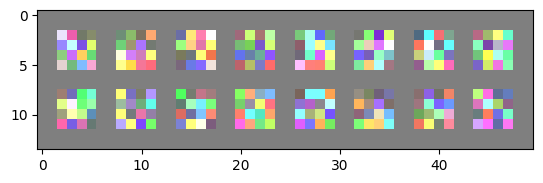

Layer 1: Loss_D: 1.5903376340866089, Loss_G: -0.762603759765625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


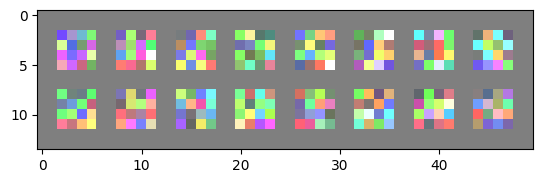

Layer 1: Loss_D: -1.2014985084533691, Loss_G: -0.5727642178535461


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


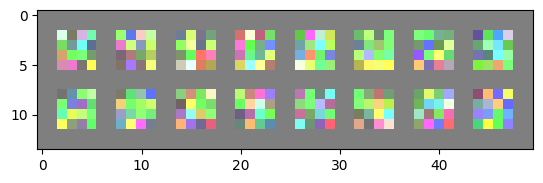

Layer 1: Loss_D: -0.5935043096542358, Loss_G: 0.6769994497299194


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


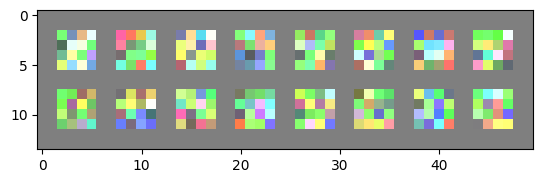

Layer 1: Loss_D: 0.980182409286499, Loss_G: 0.30824339389801025


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


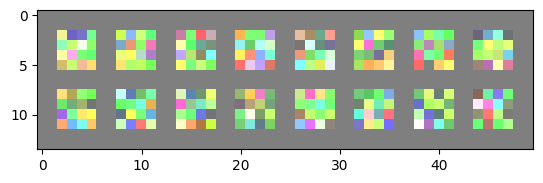

Layer 1: Loss_D: -0.06489628553390503, Loss_G: -0.36805763840675354


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


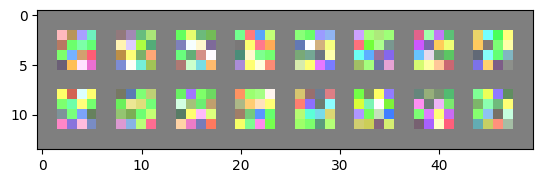

Layer 1: Loss_D: 0.04844960570335388, Loss_G: 0.3172798156738281


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


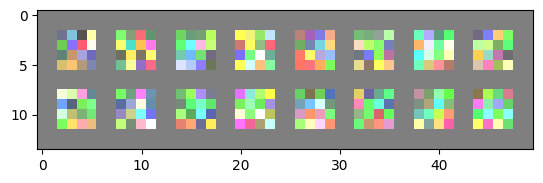

Layer 1: Loss_D: -1.176318883895874, Loss_G: -0.9952192306518555


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


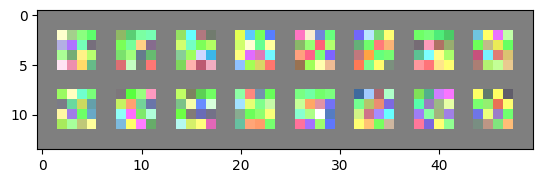

Layer 1: Loss_D: 0.7140269875526428, Loss_G: 0.816659688949585


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


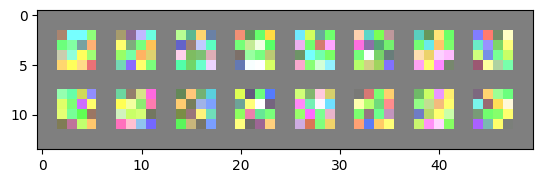

Layer 1: Loss_D: -0.9499835968017578, Loss_G: 0.22005048394203186


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


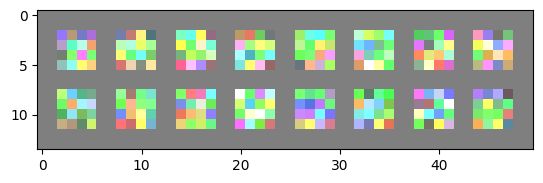

Layer 1: Loss_D: 0.2256864607334137, Loss_G: 0.22687046229839325


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


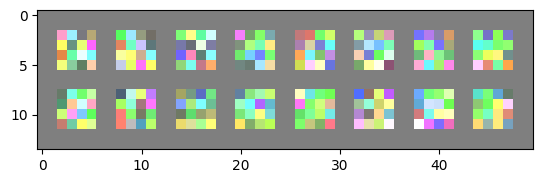

Layer 1: Loss_D: 0.6332967281341553, Loss_G: -0.08496035635471344


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


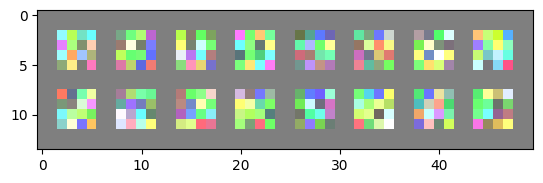

Layer 1: Loss_D: 0.01713809370994568, Loss_G: -0.2562408447265625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


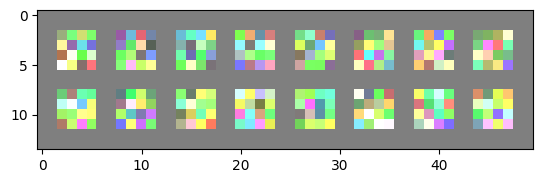

Layer 1: Loss_D: 0.6031491756439209, Loss_G: -0.8172717690467834


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


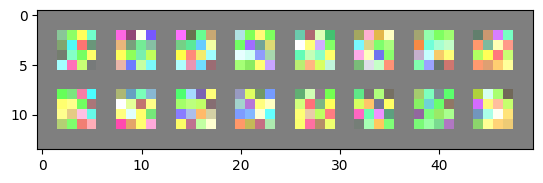

Layer 1: Loss_D: 0.8698232173919678, Loss_G: 0.40610384941101074


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


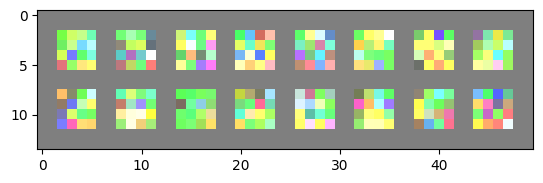

Layer 1: Loss_D: 0.6963315606117249, Loss_G: -0.6007483005523682


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


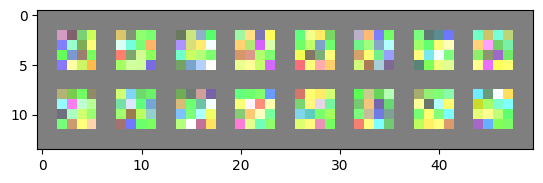

Layer 1: Loss_D: 0.22774697840213776, Loss_G: -0.41993802785873413


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


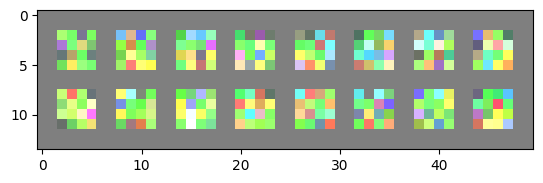

Layer 1: Loss_D: -0.20275366306304932, Loss_G: 0.20663541555404663


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


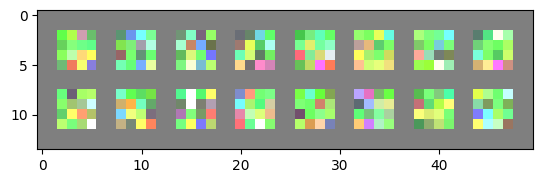

Layer 1: Loss_D: 0.7117317318916321, Loss_G: -0.03983402997255325


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


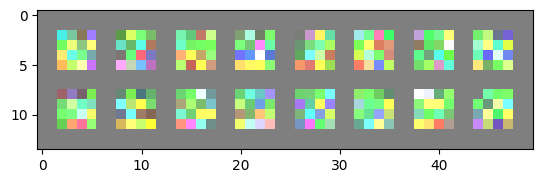

Layer 1: Loss_D: -0.07696329057216644, Loss_G: -0.6454564929008484


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


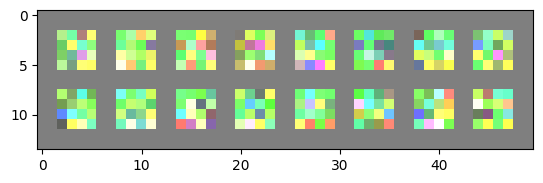

Layer 1: Loss_D: -2.8213531970977783, Loss_G: -0.9292603135108948


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


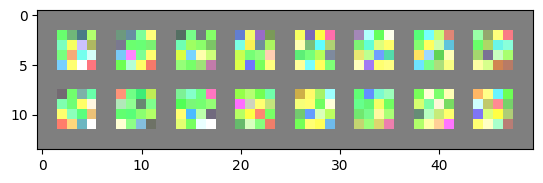

Layer 1: Loss_D: 0.4691198170185089, Loss_G: -0.027929946780204773


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


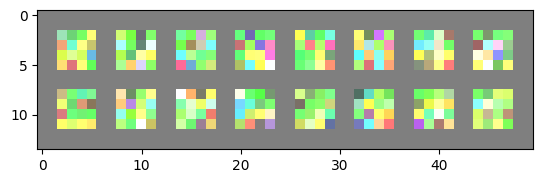

Layer 1: Loss_D: 0.5559693574905396, Loss_G: -0.15889722108840942


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


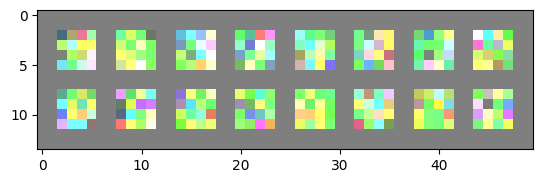

Layer 1: Loss_D: 0.21189400553703308, Loss_G: -0.6748602390289307


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


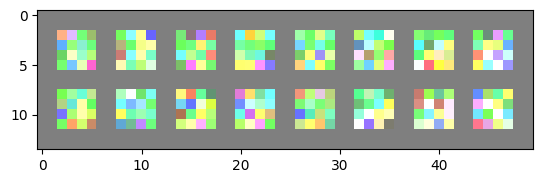

Layer 1: Loss_D: 0.9927140474319458, Loss_G: -0.26337671279907227


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


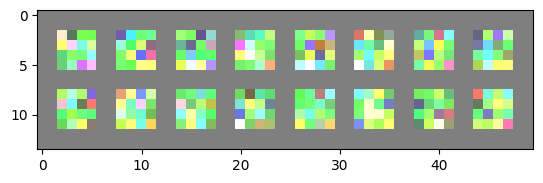

Layer 1: Loss_D: -1.4077374935150146, Loss_G: -0.5944916605949402
Alpha after grow: 1.0


KeyboardInterrupt: 

In [181]:
for layer in range(4):
    print(f'Training layer: {layer+1}')
    alpha = 0
    
    # Add the G and D blocks
    d_new_params = d_32.add_disc_block(layer_num=layer)
    g_new_params = g_32.add_gen_block(layer_num=layer)
    
    ema.register()
    
    print(d_32)
    print(g_32)
    
    
    for epoch_grow in range(25):
        for i, data in enumerate(dataloader):
            real_images, _ = data
            real_images = real_images.to(device)
        
            noise_tensor = torch.randn(batch_size, 512, 1, 1, device=device)

            with torch.no_grad():
                gen_images = g_32(noise_tensor, alpha=alpha)
            
            real_images = F.interpolate(real_images, size=gen_images.shape[2:])
            
            gen_labels = torch.zeros((batch_size, 1)).to(device)
            real_labels = torch.ones((batch_size, 1)).to(device)

            combined_images = torch.cat((real_images, gen_images))
            combined_labels = torch.cat((real_labels, gen_labels))
            
            #print(gen_images.shape, real_images.shape)
            
            # First update the D model
            d_32.zero_grad()
            d_outputs_combined = d_32(combined_images, alpha=alpha) 
            
            # Init the first D optim
            if optim_D is None:
                optim_D = torch.optim.Adam(d_32.parameters(), lr=0.00001, betas=(0, 0.99), eps=10**(-8))
            else:
                # Safely add new discriminator parameters
                existing_d_params = set(p for group in optim_D.param_groups for p in group['params'])
                new_d_params = set(d_new_params) - existing_d_params
                if new_d_params:
                    optim_D.add_param_group({'params': list(new_d_params)})
                    
            # Init the first G optim
            if optim_G is None:
                optim_G = torch.optim.Adam(g_32.parameters(), lr=0.00001, betas=(0, 0.99), eps=10**(-8))
            else:
                # Safely add new generator parameters
                existing_g_params = set(p for group in optim_G.param_groups for p in group['params'])
                new_g_params = set(g_new_params) - existing_g_params
                if new_g_params:
                    optim_G.add_param_group({'params': list(new_g_params)})

            #loss_d = criterion(d_outputs_combined, combined_labels)
            loss_d, _ = criterion(d_32, real_images, gen_images.detach(), alpha)
            loss_d.backward()
            optim_D.step()
            
            # Generate new images for updating G
            noise_tensor = torch.randn((batch_size, 512, 1, 1)).to(device)

            # Next update the G model, 
            #if i % 2 == 0:  # Update generator less frequently
            g_32.zero_grad()
            gen_images = g_32(noise_tensor, alpha=alpha)  
            d_outputs_generated = d_32(gen_images, alpha=alpha)
            #loss_g = criterion(d_outputs_generated, real_labels)
            _, loss_g = criterion(d_32, real_images, gen_images, alpha)
            loss_g.backward()
            optim_G.step()
            
            ema.update()
        
        fake_images = generate_images(g_32, noise_tensor)
        imshow(torchvision.utils.make_grid(fake_images.cpu()))
        print(f'Layer {layer+1}: Loss_D: {loss_d.item()}, Loss_G: {loss_g.item()}')
        
        alpha += 1/25
        alpha = round(alpha, 2)
        
    print(f'Alpha after grow: {alpha}')
    for epoch_train in range(100):
        for i, data in enumerate(dataloader):
            real_images, _ = data
            real_images = real_images.to(device)

            noise_tensor = torch.randn((batch_size, 512, 1, 1), device=device)

            with torch.no_grad():
                gen_images = g_32(noise_tensor, alpha=alpha)

            real_images = F.interpolate(real_images, size=gen_images.shape[2:])
            
            gen_labels = torch.zeros((batch_size, 1)).to(device)
            real_labels = torch.ones((batch_size, 1)).to(device)

            combined_images = torch.cat((real_images, gen_images))
            combined_labels = torch.cat((real_labels, gen_labels))

            # First update the D model
            d_32.zero_grad()
            d_outputs_combined = d_32(combined_images, alpha=alpha) 
            
            #loss_d = criterion(d_outputs_combined, combined_labels)
            loss_d, _ = criterion(d_32, real_images, gen_images.detach(), alpha)
            loss_d.backward()
            optim_D.step()
            
            # Generate new images for updating G
            noise_tensor = torch.randn((batch_size, 512, 1, 1)).to(device)

            # Next update the G model, 
            #if i % 2 == 0:  # Update generator less frequently
            g_32.zero_grad()
            gen_images = g_32(noise_tensor, alpha=alpha)  # Gen new images for training G
            d_outputs_generated = d_32(gen_images, alpha=alpha)
            #loss_g = criterion(d_outputs_generated, real_labels)
            _, loss_g = criterion(d_32, real_images, gen_images, alpha)
            loss_g.backward()
            optim_G.step()
            
            ema.update()
    
    fake_images = generate_images(g_32, noise_tensor)
    print(f'FINAL | Layer {layer+1}: Loss_D: {loss_d.item()}, Loss_G: {loss_g.item()}')
    imshow(torchvision.utils.make_grid(real_images.cpu()))
    imshow(torchvision.utils.make_grid(fake_images.cpu()))

## WGAN-GP Loss function definition